## Vehicle Detection and Tracking Pipeline

#### This project represents a software pipeline to detect vehicles in a video.

**Pipeline Steps:**

* [Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images.](#A1)
* [Train a classifier Linear SVM classifier](#A2)

* [Implement a sliding-window technique and use the trained classifier to search for vehicles in images.](#B)
* [Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.](#C)
* [Estimate a bounding box for the detected vehicles.](#D)
* [The Pipeline](#E)

## Pre: Imports, Paths, and some helper method


In [1]:
%matplotlib inline
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio


In [2]:
# Path
root = "./"
test_img_path = root + "test_images/" +"*.jpg"
test_video_path = root + "test_videos/"
output_img_path = root + "output_images/"
output_video_path = root + "output_video/"
dataset_path = root + "Dataset/"

In [3]:
# CONSTANTS
SEED = 43
COLOR_SPACE = 'YUV'     # RGB, HSV, LUV, HLS, YUV, YCrCb
SAPTIAL_SIZE = (32,32)  # Spatial binning dimensions
HIST_BINS = 32          # Number of histogram bins
HOG_CHANNEL = 0         # 0, 1, 2, or "ALL"
PIX_PER_CELL = 12       # HOG pixels per cell
CELL_PER_BLOCK = 4      # HOG cells per block
ORIENT = 9              # HOG orientations

spatial_feat = True     # Spatial features on or off
hist_feat = True        # Histogram features on or off
hog_feat = True         # HOG features on or off

In [4]:
def read_img(file_list, *args):
    '''
    Funciton to read images in RGB format from a path 
    '''
    return np.array([cv2.cvtColor(cv2.imread(files,*args),cv2.COLOR_BGR2RGB) for files in file_list])

In [5]:
def show_image(instances, Num_img_to_show = 20,*args ):
    '''
    Function to display images from a collection
    '''
    num_img = instances.shape[0]
    i = 0
    for img in enumerate(instances):
        fig , (axis1, axis2) = plt.subplots(1, 2, figsize=(15,10))
        axis1.imshow(instances[i],*args)
        axis2.imshow(instances[i+1],*args)
        axis1.axis("off")
        axis2.axis("off")
        
        if (i+2 >= Num_img_to_show or i+2>=num_img ):
            return
        else:
            i = i + 2
    plt.show()

In [6]:
def show_images_two_sets(instances01,instances02,
                         title01="", title02="" ,
                         Num_img_to_show = 20,
                         cmap1="viridis",cmap2="viridis" ):
    '''
    Function to display images from two collection
    '''
   
    
    num_img = instances01.shape[0]
    i = 0
    for img in enumerate(instances01):
        fig , (axis1, axis2) = plt.subplots(1, 2, figsize=(13,5))
        
        axis1.imshow(instances01[i],cmap = cmap1)
        axis2.imshow(instances02[i],cmap = cmap2)
        axis1.set_title(title01 + " "+str(i+1))
        axis2.set_title(title02+ " "+str(i+1))
        axis1.axis("off")
        axis2.axis("off")
        
        if (i >= Num_img_to_show or i>=num_img ):
            return
        else:
            i = i + 1
    plt.show()

In [7]:
def plot_two_imgs(instances01,instances02,
                         title01="", title02="" ,
                         Num_img_to_show = 20,
                         cmap1="viridis",cmap2="viridis" ):
    '''
    Function to display images from two collection
    '''
    fig , (axis1, axis2) = plt.subplots(1, 2, figsize=(5,5))
        
    axis1.imshow(instances01,cmap = cmap1)
    axis2.imshow(instances02,cmap = cmap2)
    axis1.set_title(title01 )
    axis2.set_title(title02)
    axis1.axis("off")
    axis2.axis("off")
    plt.show()

In [8]:
def plot_samples(instances, img_size, channel = 3 ,images_per_row=10, **options):
    size = img_size
    
    
    images_per_row = min(len(instances), images_per_row)
    
    images = [instance.reshape(size,size,channel) for instance in instances]
    
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    
    image = np.concatenate(row_images, axis=0)
    plt.figure(figsize=(10,8))
    plt.imshow(image,  **options)
    plt.axis("off")

In [9]:
def get_image_size(img):
    return (img[0].shape[1],img[0].shape[0])

In [10]:

car_imgs_path = shuffle(glob.glob(dataset_path+"vehicles/**/*.png"),random_state=SEED)
non_car_imgs_path = shuffle(glob.glob(dataset_path+"non-vehicles/**/*.png"),random_state=SEED)

car_imgs = read_img(car_imgs_path)
non_car_imgs= read_img(non_car_imgs_path)

Total car images: 8792


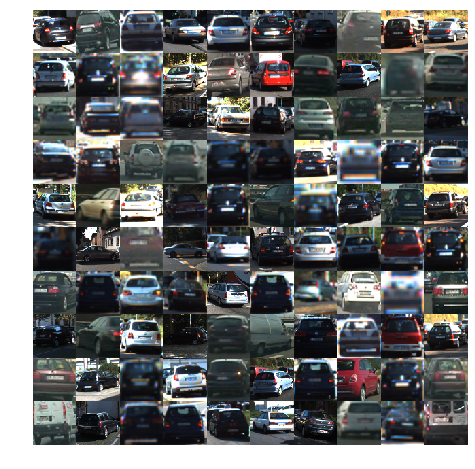

In [11]:
print ("Total car images: {}".format(car_imgs.shape[0]))
plot_samples (car_imgs[0:100], 64)

Total non_car images: 8968


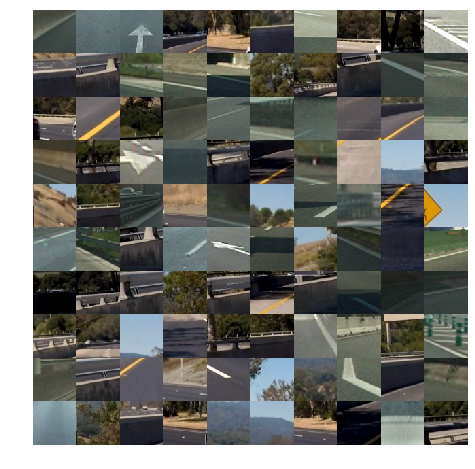

In [12]:
print ("Total non_car images: {}".format(non_car_imgs.shape[0]))
plot_samples (non_car_imgs[0:100], 64)

<a id='A1'></a>
## A1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images 

In [13]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,  vis=True, feature_vec=True):
    

    
    if vis:
        features, hog_image = hog(img, 
                              orientations=orient,
                              pixels_per_cell=(pix_per_cell, pix_per_cell), 
                              cells_per_block=(cell_per_block, cell_per_block),
                              visualise = vis,
                              feature_vector=feature_vec,
                              block_norm ="L2-Hys"        
                             )
        return features, hog_image
    else: 
        features = hog(img, 
                              orientations=orient,
                              pixels_per_cell=(pix_per_cell, pix_per_cell), 
                              cells_per_block=(cell_per_block, cell_per_block),
                              visualise = vis,
                              feature_vector=feature_vec,
                              block_norm ="L2-Hys"        
                             )
        return features
    

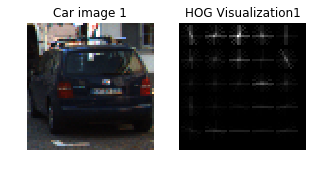

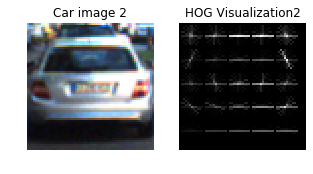

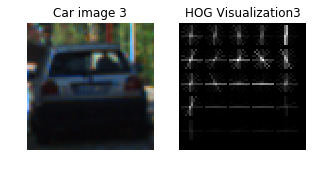

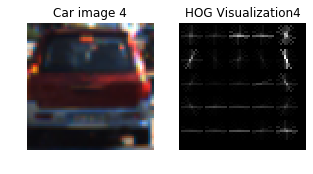

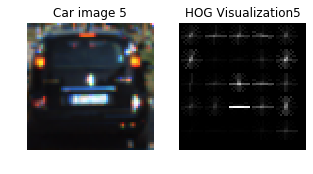

In [14]:
for i, img in enumerate(car_imgs[55:60]):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    features, hog_img = get_hog_features(gray, ORIENT,PIX_PER_CELL, CELL_PER_BLOCK )
    plot_two_imgs(img, hog_img,
                  title01="Car image " + str(i+1), 
                  title02="HOG Visualization"+ str(i+1), 
                  cmap2="gray" )

In [15]:
# Function to compute binned color features  
def bin_spatial(img, size):
    features = cv2.resize(img, size).ravel() 
    return features

# Function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenates the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Returns the individual histograms, bin_centers and feature vector
    return hist_features

In [16]:
def extract_features(imgs, 
                        hist_bins,spatial_size, orient, 
                        pix_per_cell, cell_per_block, hog_channel, color_space='RGB', 
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # A list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        
        # Color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                    
                    
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    
    # Return list of feature vectors
    return features

In [17]:
car_features = extract_features(car_imgs,
                                color_space=COLOR_SPACE,
                                spatial_size = SAPTIAL_SIZE,
                                hist_bins=HIST_BINS, 
                                orient=ORIENT, 
                                pix_per_cell=PIX_PER_CELL, 
                                cell_per_block=CELL_PER_BLOCK, 
                                hog_channel=HOG_CHANNEL, 
                                hist_feat=hist_feat, 
                                hog_feat=hog_feat)

notcar_features = extract_features(non_car_imgs,
                                color_space=COLOR_SPACE,
                                spatial_size = SAPTIAL_SIZE,
                                hist_bins=HIST_BINS, 
                                orient=ORIENT, 
                                pix_per_cell=PIX_PER_CELL, 
                                cell_per_block=CELL_PER_BLOCK, 
                                hog_channel=HOG_CHANNEL, 
                                hist_feat=hist_feat, 
                                hog_feat=hog_feat)


In [18]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)


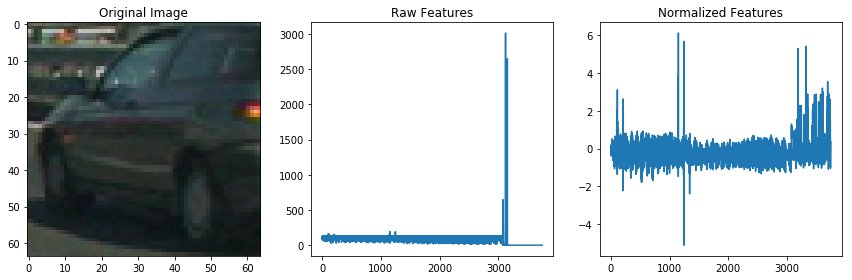

In [19]:
#car_ind = np.random.randint(0, len(car_imgs))
car_ind = 45
fig = plt.figure(figsize=(12,4))
plt.subplot(131)

plt.imshow(car_imgs[car_ind])
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()


<a id='A2'></a>
## A2. Train a classifier Linear SVM classifier


In [20]:
# Create an array stack of labels vector
labels = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(scaled_X, 
                                                    labels, 
                                                    test_size=0.2,
                                                    random_state=SEED)

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

print("Train Size: {}".format(len(X_train)))
print("Test Size: {}".format(len(X_test)))


Train Size: 14208
Test Size: 3552


In [21]:
parameters = {'kernel':('linear', 'rbf'), 'C':[0.001,1,10,100]}
svc = SVC()
clf = GridSearchCV(svc, parameters, verbose=1)
clf.fit(X_train[:1000], y_train[:1000])

print(clf.best_score_, clf.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   48.6s finished


0.967 {'kernel': 'rbf', 'C': 10}


In [22]:
svc = SVC(C=10, kernel='rbf')
svc.fit(X_train, y_train)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9952


In [23]:
sample_size = 10
print('My SVC predicts:     ', svc.predict(X_test[0:sample_size]))
print('For these', sample_size, 'labels: ', y_test[0:sample_size])

My SVC predicts:      [0. 1. 1. 1. 0. 1. 0. 1. 0. 1.]
For these 10 labels:  [0. 1. 1. 1. 0. 1. 0. 1. 0. 1.]


<a id='B'></a>
## B. Implementing a sliding-window technique and use the trained classifier to search for vehicles in images.

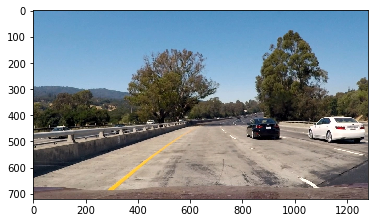

In [24]:
test_imgs = read_img(glob.glob(test_img_path))
plt.imshow(test_imgs[3])

In [25]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to defined values
    
    if x_start_stop[0] == None:
        x_start_stop[0] = int(img.shape[1]/5)
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = int(img.shape[0] * 0.5)
    if y_start_stop[1] == None:
        y_start_stop[1] = int(img.shape[0] * 0.7)
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list


In [26]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255, 60, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
   
    # Return the image copy with boxes drawn
    return imcopy

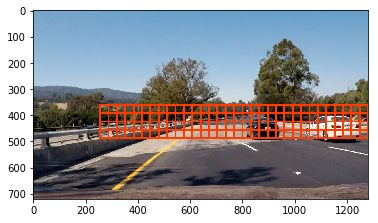

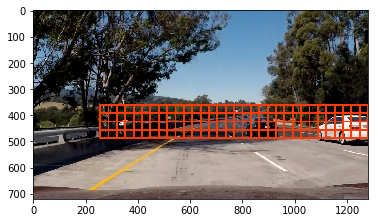

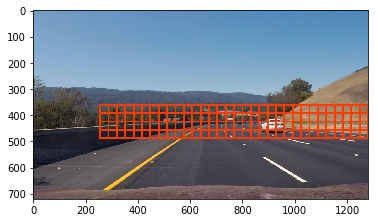

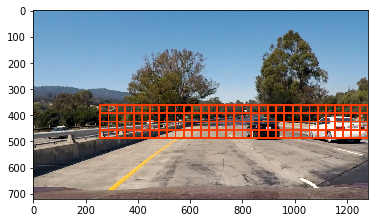

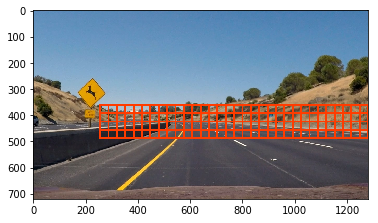

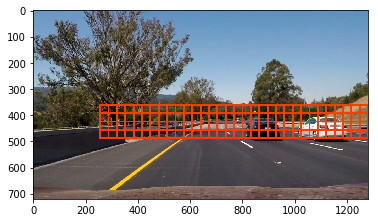

In [27]:
for img in test_imgs:
    windows =  slide_window(img)
    window_img = draw_boxes(img, windows)
    plt.subplots(1,1)    
    plt.imshow(window_img)


In [28]:
def extract_features(imgs, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, color_space,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for image in imgs:
        file_features = []

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))
    
    # Return list of feature vectors
    return features

In [29]:
def single_img_features(img,  spatial_size,
                        hist_bins, orient, color_space,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    
    # Define an empty list to receive features
    img_features = []
    
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        # Append features to list
        img_features.append(hist_features)
    
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append features to list
        img_features.append(hog_features)

    # Return concatenated array of features
    return np.concatenate(img_features)

In [30]:
def search_windows(img, windows, clf, scaler, 
                    spatial_size, hist_bins, 
                     orient, color_space,
                    pix_per_cell, cell_per_block, 
                    hog_channel, spatial_feat=True, hist_range=(0, 256),
                    hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    
    # Iterate over all windows in the list
    for window in windows:
        
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features to be fed to classifier
        
        #print (features.shape)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # Predict using your classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    
    # Return windows for positive detections
    return on_windows

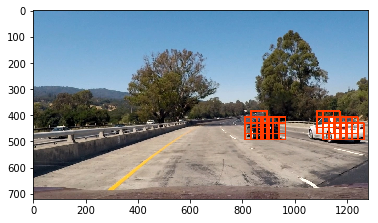

In [31]:
pip_test= test_imgs[3]
# Min and max in y to search in slide_window()
y_start_stop = [None, None] 


windows = slide_window(pip_test, x_start_stop=[None, None], y_start_stop = y_start_stop, 
                    xy_window=(64,64), xy_overlap=(0.64, 0.64))

hot_windows = search_windows(pip_test, windows, svc, X_scaler, color_space=COLOR_SPACE, 
                        spatial_size=SAPTIAL_SIZE, hist_bins=HIST_BINS, 
                        orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                        cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=HOG_CHANNEL, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

draw_image = np.copy(pip_test)
window_img = draw_boxes(draw_image, hot_windows, color=(255, 60, 0), thick=6)                    

plt.imshow(window_img)

<a id='C'></a>
## C. Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.


In [32]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
 
def apply_threshold(heatmap, threshold = 2):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


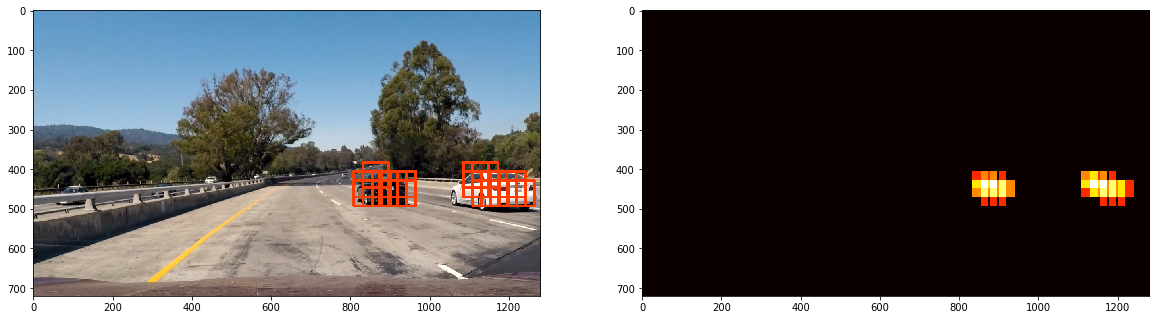

In [33]:
heatmap = np.zeros_like(pip_test[:,:,0].astype(np.float))
heatmap = add_heat(heatmap, hot_windows)
heatmap = apply_threshold(heatmap,2)

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(window_img)

plt.subplot(122)
plt.imshow(heatmap, cmap='hot')

<a id='D'></a>
## D. Estimate a bounding box for the detected vehicles.

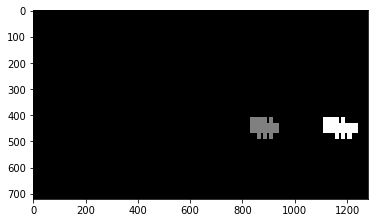

In [34]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    
    bboxes = []
    for car_number in range(1, labels[1]+1):
        
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (47,227,145), 6)
        bboxes.append(bbox)
    img = draw_boxes(img, bboxes)
    # Return the image
    return img



#heatmap = np.clip(heatmap-2, 0, 255)

labels = label(heatmap)

plt.imshow(labels[0], cmap='gray')

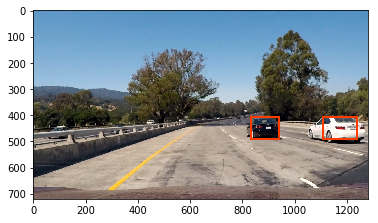

In [35]:
draw_img = np.copy(pip_test)
draw_img = draw_labeled_bboxes(draw_img, labels)


plt.imshow(draw_img)

<a id='E'></a>
## E. Video Pipeline


In [36]:
num_frame_to_keep = 6
show_image = True

class Collection:
    def __init__(self):
        self.bboxes = []
    
    def add_bboxes(self, bboxes):
        self.bboxes.append(bboxes)
        self.bboxes = self.bboxes[-num_frame_to_keep:]
    
    def heatmap(self):
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        for bboxes in self.bboxes:
            add_heat(heatmap, bboxes)
        heatmap = apply_threshold(heatmap)
        labels = label(heatmap)
        return heatmap,labels
    
collection = Collection()  

def video_pipeline(img):
    global show_image
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop = y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.64, 0.64))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=COLOR_SPACE, 
                        spatial_size=SAPTIAL_SIZE, hist_bins=HIST_BINS, 
                        orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                        cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=HOG_CHANNEL, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    
    collection.add_bboxes (hot_windows)
    heatmap, labels = collection.heatmap()
    img = draw_labeled_bboxes(img, labels)
    
    if show_image:
        draw_image = np.copy(img)
        window_img = draw_boxes(draw_image, hot_windows, color=(255, 60, 0), thick=6) 

        plt.figure(figsize=(15, 8))
        plt.subplot(131)
        plt.imshow(window_img)

        plt.subplot(132)
        plt.imshow(heatmap, cmap='hot')

        plt.subplot(133)
        plt.imshow(labels[0], cmap='gray')
        
    
    return img    

[MoviePy] >>>> Building video ./output_video/test_video.mp4
[MoviePy] Writing video ./output_video/test_video.mp4


 83%|████████▎ | 5/6 [00:08<00:01,  1.69s/it]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/test_video.mp4 



CPU times: user 8.44 s, sys: 59.6 ms, total: 8.5 s
Wall time: 8.67 s


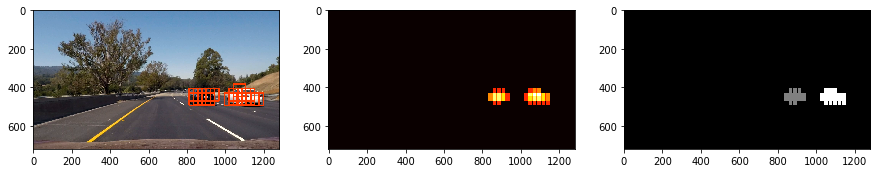

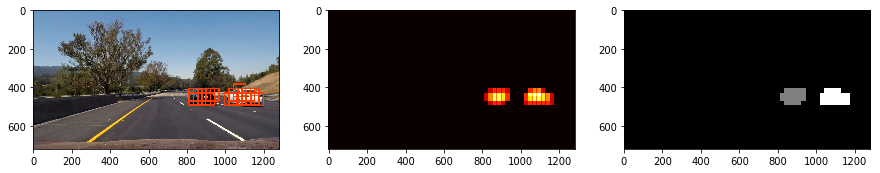

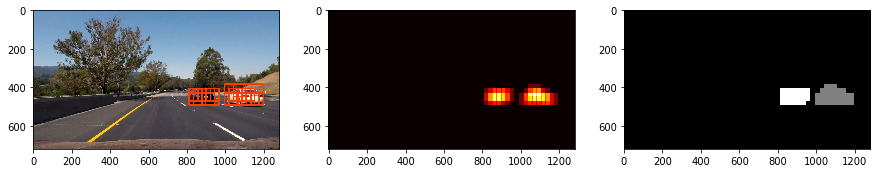

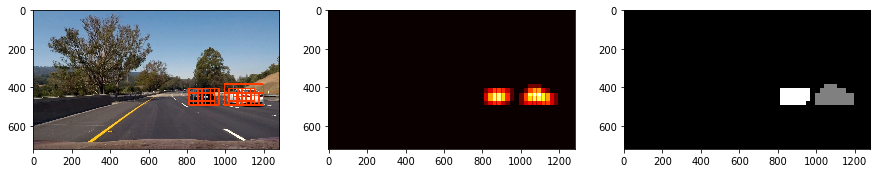

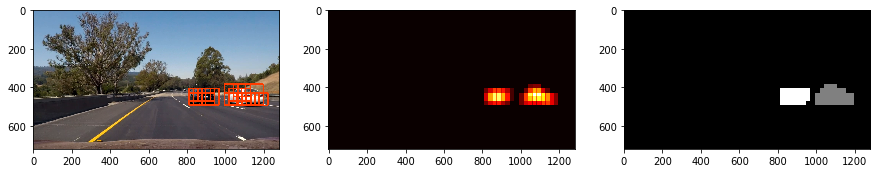

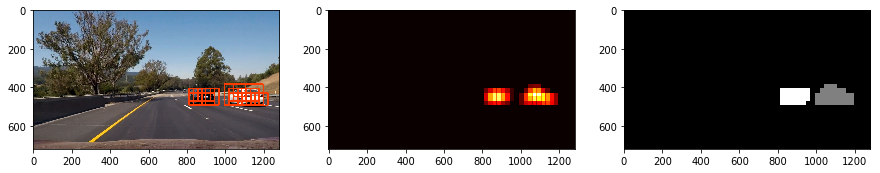

In [37]:
imageio.plugins.ffmpeg.download()
video_name = "test_video.mp4"
test_video = test_video_path+video_name

out_video = output_video_path+video_name


video = VideoFileClip(test_video).subclip(0.0,0.2)

clip = video.fl_image(video_pipeline)
%time clip.write_videofile(out_video, audio=False)

In [38]:
show_image = False

video_name = "project_video.mp4"
test_video = test_video_path+video_name

out_video = output_video_path+video_name


video = VideoFileClip(test_video)

clip = video.fl_image(video_pipeline)
%time clip.write_videofile(out_video, audio=False)

[MoviePy] >>>> Building video ./output_video/project_video.mp4
[MoviePy] Writing video ./output_video/project_video.mp4


100%|█████████▉| 1260/1261 [34:18<00:01,  1.63s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/project_video.mp4 

CPU times: user 34min 12s, sys: 2.08 s, total: 34min 14s
Wall time: 34min 19s


In [39]:
HTML("""
     <iframe width="560" height="315" 
     src="https://www.youtube.com/embed/DwudAsXfoIM" 
     frameborder="0" allow="accelerometer; 
     autoplay; encrypted-media; gyroscope; 
     picture-in-picture" allowfullscreen>
     </iframe>
     """)